In [1]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import collections
from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

In [2]:
# https://stackoverflow.com/questions/43147983/could-not-create-cudnn-handle-cudnn-status-internal-error
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Get the data

In [3]:
num_forecast_steps = 7 * 4 # 28 days

X, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data()

num_data_to_consider = 365 * 10 # 10 years worth of data
assert(num_data_to_consider > num_forecast_steps)

X_train = X[-num_data_to_consider:-num_forecast_steps, :]
anoms_train = anoms[-num_data_to_consider:-num_forecast_steps]
clims_train = clims[-num_data_to_consider:-num_forecast_steps]
temps_train = temps[-num_data_to_consider:-num_forecast_steps]
dates_train = dates[-num_data_to_consider:-num_forecast_steps]

X_test = X[-num_forecast_steps:, :]
anoms_test = anoms[-num_forecast_steps:]
clims_test = clims[-num_forecast_steps:]
temps_test = temps[-num_forecast_steps:]
dates_test = dates[-num_forecast_steps:]

is_predicting_anomaly = True
if is_predicting_anomaly:
    Y_train = anoms_train
    Y_test = anoms_test
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train
    Y_test = temps_test
    print(f"Y is temperature directly!")


['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 27.0, lon_oi: 261.0
Y is temperature anomaly!


In [4]:
print(clims.shape)

(13283,)


In [16]:
years_in_data = dates.dt.year
first_year = min(years_in_data)
last_year = max(years_in_data)
print(first_year)
print(last_year)

print(index_to_columnstr)

num_forecast_steps = 7 * 4 # 28 days

1982
2018
{0: 'tmp2m_shift29', 1: 'tmp2m_shift29_anom', 2: 'tmp2m_shift58', 3: 'tmp2m_shift58_anom', 4: 'rhum_shift30', 5: 'pres_shift30', 6: 'nmme_wo_ccsm3_nasa', 7: 'nmme0_wo_ccsm3_nasa', 8: 'mei_shift45', 9: 'phase_shift17', 10: 'sst_2010_1_shift30', 11: 'sst_2010_2_shift30', 12: 'sst_2010_3_shift30', 13: 'icec_2010_1_shift30', 14: 'icec_2010_2_shift30', 15: 'icec_2010_3_shift30', 16: 'wind_hgt_10_2010_1_shift30', 17: 'wind_hgt_10_2010_2_shift30'}


(3622,)


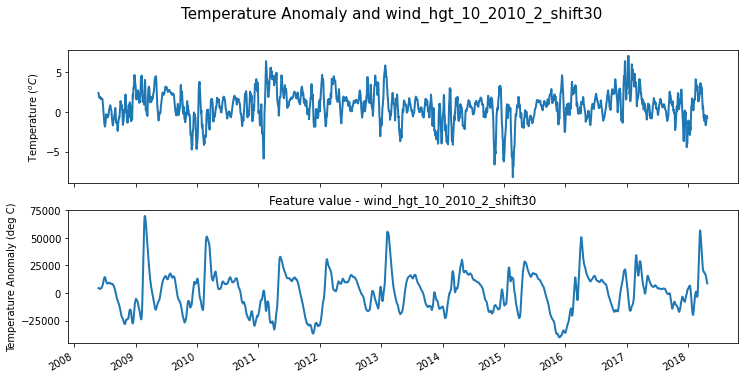

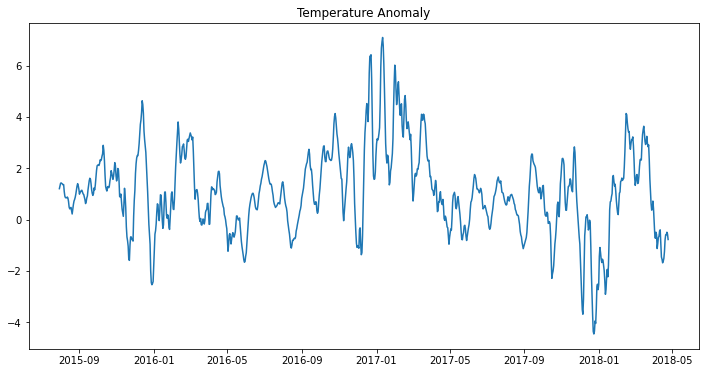

In [17]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "wind_hgt_10_2010_2_shift30"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title(f"Feature value - {feature_str}")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature Anomaly and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [18]:
def build_model(observed_time_series):
    weekly = tfp.sts.Seasonal(
        num_seasons=26, 
        observed_time_series=observed_time_series,
        num_steps_per_season=14, 
        name='biweekly'
    )
#     seasonal = tfp.sts.Seasonal(
#         num_seasons=4, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=91, 
#         name='seasonal'
#     )
#     monthly = tfp.sts.Seasonal(
#         num_seasons=12,
#         observed_time_series=observed_time_series,
#         num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
#         drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
#         initial_effect_prior=tfd.Normal(loc=0., scale=5.),
#         name='month_of_year',
#     )
#     features_effect = tfp.sts.DynamicLinearRegression(
#     features_effect = tfp.sts.LinearRegression(
#         design_matrix=X, #- np.mean(X), 
#         design_matrix=X_train, #- np.mean(X_train), 
#         name='other_features'
#     )   
#     autoregressive = tfp.sts.Autoregressive(
#         order=1,
#         observed_time_series=observed_time_series,
#         name='autoregressive'
#     )
#     semilocal = tfp.sts.SemiLocalLinearTrend()
    model = tfp.sts.Sum([
        weekly,
#         seasonal,
#         monthly,
#         features_effect,
#         autoregressive
#         semilocal

        ],
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)
print(variational_posteriors)

tfp.distributions.JointDistributionNamed("build_factored_surrogate_posterior_JointDistributionNamed", batch_shape={biweekly/_drift_scale: [], observation_noise_scale: []}, event_shape={biweekly/_drift_scale: [], observation_noise_scale: []}, dtype={biweekly/_drift_scale: float32, observation_noise_scale: float32})


50
99.47010588645935 seconds


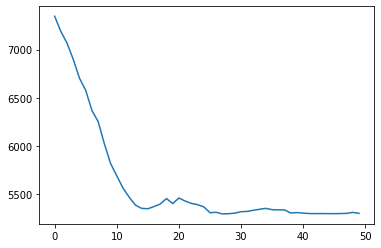

In [19]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 50
print(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temperature_model.joint_log_prob(
        observed_time_series=Y_train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds")
plt.plot(elbo_loss_curve)
plt.show()

In [20]:
print(elbo_loss_curve)

tf.Tensor(
[7346.35   7187.827  7066.7954 6898.0454 6703.411  6578.114  6369.3794
 6254.1416 6024.7373 5820.202  5692.257  5565.235  5470.3643 5388.457
 5355.2173 5351.069  5373.999  5400.1704 5456.6353 5404.533  5462.459
 5431.2036 5406.6724 5393.4565 5371.0063 5310.202  5314.3125 5297.5195
 5299.573  5305.4624 5320.5635 5323.4355 5335.3516 5345.73   5355.112
 5341.684  5339.6675 5338.9844 5307.006  5311.3794 5305.521  5301.476
 5300.7573 5301.4326 5300.5264 5300.6284 5300.987  5303.327  5313.3877
 5303.201 ], shape=(50,), dtype=float32)


In [21]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(50)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.8357712030410767 +- 0.008408484049141407
biweekly/_drift_scale: 3.1318752765655518 +- 0.06354103237390518


## Forecasting

In [22]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train[-10 * 365:],
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

time elapsed = 62.630282163619995


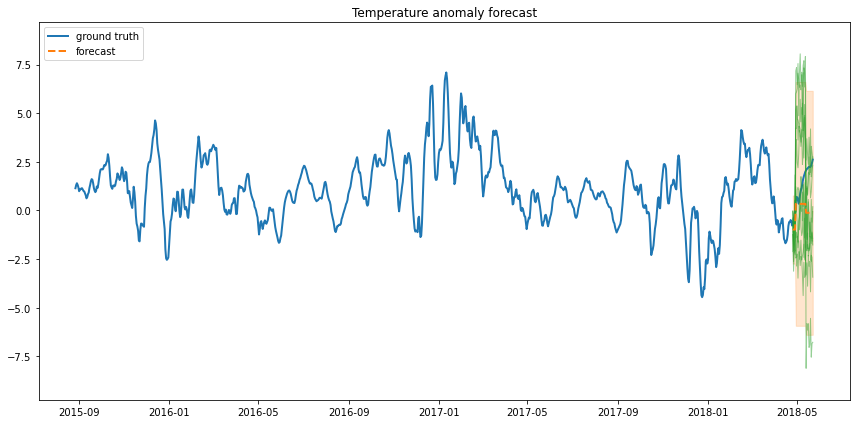

In [27]:
num_samples=10

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    plot_temp = False
    if plot_temp:
        fig, ax = plot_forecast(dates, anoms + clims,
                                temperature_forecast_mean + clims_test,
                                temperature_forecast_scale,
                                temperature_forecast_samples + clims_test,
                                title="Temperature forecast (predicted anomaly)",
                                plot_num=1000,
        )
    else:
        fig, ax = plot_forecast(dates, anoms,
                                temperature_forecast_mean,
                                temperature_forecast_scale,
                                temperature_forecast_samples,
                                title="Temperature anomaly forecast",
                                plot_num=1000,
        )
else:
    fig, ax = plot_forecast(dates, temps,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct value)",
                            plot_num=1000,
    )

fig.tight_layout()


In [24]:
num_to_plot_for_decomp = 10 * 365
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train[-num_to_plot_for_decomp:],
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


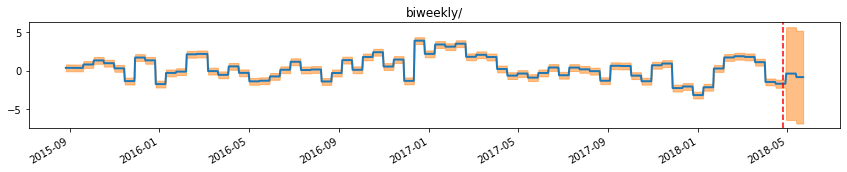

In [28]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates[-num_to_plot_for_decomp:],
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = 1000
)
for ax in axes.values():
  ax.axvline(dates.to_numpy()[-num_forecast_steps], linestyle="--", color='red')


In [15]:
print(num_data_to_consider)

3650
